<h2>1. Import library and data </h2>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import random

# For customizing plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec

# For preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# For wordcloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

# For modelling
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

palette = sns.color_palette("mako", 3)
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/ippapi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data_path = '/home/ippapi/Desktop/Python/reddit_sentiment_analysis/data/Reddit_Data.csv'

df = pd.read_csv(data_path)

display(df.head())

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


<h2>2. Preprocessing data </h2>

In [6]:
df.isna().sum()

clean_comment    100
category           0
dtype: int64

In [7]:
df.dropna(inplace = True)
df.isna().sum()

clean_comment    0
category         0
dtype: int64

In [8]:
chars = set()

for inx, row in df.iterrows():
    chars = chars | set(row['clean_comment'])

chars = sorted(list(chars))
vocab_size = len(chars)

print(chars)
print(vocab_size)

['\t', '\n', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '@', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '¢', '£', '§', '¨', '©', '«', '\xad', '®', '¯', '°', '±', '´', '·', '¸', '»', '¿', '×', 'à', 'á', 'ã', 'ä', 'å', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ù', 'ú', 'ü', 'ā', 'ą', 'č', 'ď', 'ē', 'ė', 'ę', 'ī', 'į', 'ō', 'œ', 'ś', 'š', 'ũ', 'ū', 'ų', 'ž', 'ɔ', 'ɕ', 'ə', 'ɛ', 'ɣ', 'ɥ', 'ɲ', 'ɾ', 'ʁ', 'ʃ', 'ʎ', 'ʒ', 'ʔ', 'ʰ', 'ʲ', 'ʷ', 'ː', 'ˠ', '̄', '̥', '̪', '̵', '̿', '͇', '͜', '͞', '͡', 'χ', 'а', 'б', 'в', 'д', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'х', 'ц', 'ч', 'ы', 'ь', 'ю', 'ө', '֑', '֖', '֣', '֥', 'ְ', 'ֲ', 'ִ', 'ֶ', 'ַ', 'ָ', 'ֹ', 'ּ', 'ֽ', '׃', '؟', 'آ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ج', 'ح', 'خ', 'د', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ع', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'و', 'ي', 'ً', 'ٍ', 'َ', 'ُ', 'ِ', 

In [9]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html_tag(text):
    return re.sub('<.*?>', "", text)

def remove_email_addr(text):
    return re.sub('[\w\.-]+@[\w\.-]+\.\w+', "", text)

def remove_hashtag(text):
    return re.sub('#[_]*[a-z]+', "", text)

def remove_special_character(text):
    return re.sub("[^a-zA-Z0-9 ]+", "", text)

# Applying remove function
df['clean_comment'] = df['clean_comment'].apply(remove_URL)
df['clean_comment'] = df['clean_comment'].apply(remove_html_tag)
df['clean_comment'] = df['clean_comment'].apply(remove_email_addr)
df['clean_comment'] = df['clean_comment'].apply(remove_hashtag)  
df['clean_comment'] = df['clean_comment'].apply(remove_special_character)

# Remove empty comment
df = df.drop(df[df['clean_comment'] == ''].index)

# Remove duplicate
df = df.drop_duplicates('clean_comment', keep = 'first')


In [10]:
chars = set()

for inx, row in df.iterrows():
    chars = chars | set(row['clean_comment'])

chars = sorted(list(chars))
vocab_size = len(chars)

print(chars)
print(vocab_size)

[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
37


In [11]:
df.shape

(36703, 2)

<h2>3. Explore data analysis </h2>

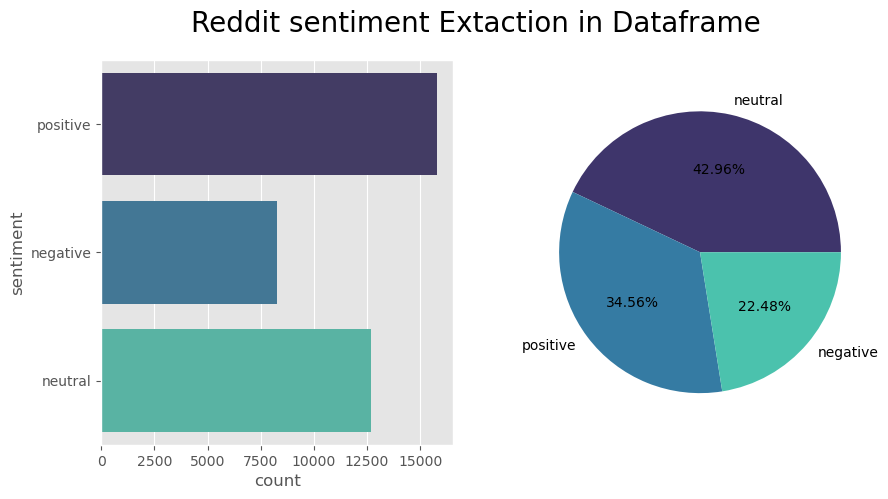

In [12]:
def get_real_label(x):
    if(x == 0):
        return 'neutral'
    elif(x == 1):
        return 'positive'
    else:
        return 'negative'
    
df['sentiment'] = df['category'].apply(get_real_label)

fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(10, 5))

sns.countplot(df['sentiment'], 
              ax = axes[0],
              palette = palette)

axes[1].pie(df['sentiment'].value_counts(),
            labels=['neutral', 'positive', 'negative'],
            autopct='%1.2f%%',
            colors = palette)

fig.suptitle('Reddit sentiment Extaction in Dataframe', 
             fontsize=20)
plt.show()

In [13]:
neutral_sample = df[df['sentiment'] == 'neutral'].sample(2)
positive_sample = df[df['sentiment'] == 'positive'].sample(2)
negative_sample = df[df['sentiment'] == 'negative'].sample(2)

print("Neutral sample:")
print("-" * 50)
for idx, row in neutral_sample.iterrows():
    print(f"clean_comment: {row['clean_comment']}")
    print("-" * 50)

print("Positive sample:")
print("-" * 50)
for idx, row in positive_sample.iterrows():
    print(f"clean_comment: {row['clean_comment']}")
    print("-" * 50)

print("Negative sample:")
print("-" * 50)
for idx, row in negative_sample.iterrows():
    print(f"clean_comment: {row['clean_comment']}")
    print("-" * 50)

Neutral sample:
--------------------------------------------------
clean_comment:  29793
--------------------------------------------------
clean_comment: bolna aata hai
--------------------------------------------------
Positive sample:
--------------------------------------------------
clean_comment: modiji wont touch hindu cause directly and give opposition point bark about
--------------------------------------------------
clean_comment:  will make sure turn 
--------------------------------------------------
Negative sample:
--------------------------------------------------
clean_comment: they have zero fear anyone protesting even raising their voice over this travesty this like the govt mocking the people witness the kind shit pulling and you have option but just sit and hapless spectator they are way over their head with the power and something someone needs step and make them eat dust 
--------------------------------------------------
clean_comment: abp news claim that 17v5 h

<h2>4. Visualize data </h2>

In [14]:
# Creating a new feature for the visualization.
df['char_num'] = df['clean_comment'].apply(lambda x: len(str(x)))

# Limit character number.
df = df.drop([idx for idx, row in df.iterrows() if len(row['clean_comment']) >= 1000])

def plot_dist3(df, feature, title):
    # Customizing fig and grid
    fig = plt.figure(constrained_layout = True, 
                     figsize = (18, 8))
    grid = gridspec.GridSpec(ncols = 3,
                             nrows = 3,
                             figure = fig)

    # Histogram.
    ax1 = fig.add_subplot(grid[:2, :2])
    sns.histplot(df.loc[:, feature],
                 kde = True,
                 ax = ax1,
                 color = '#12492f')
    ax1.set_title('Histogram')
    ax1.set(ylabel = 'Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=10))

    # Ecdf_plot.
    ax2 = fig.add_subplot(grid[2:, :2])
    sns.histplot(df.loc[:, feature],
                 ax = ax2,
                 kde = True,
                 color = '#0a2f35')
    ax2.set_title('Empirical CDF')
    ax2.set(ylabel = 'Cumulative Probability')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=10))

    # Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    sns.boxplot(y = feature, 
                data=df, 
                ax = ax3, 
                color = '#f56038')
    ax3.set_title('Box Plot')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.suptitle(f'{title}', fontsize=24)

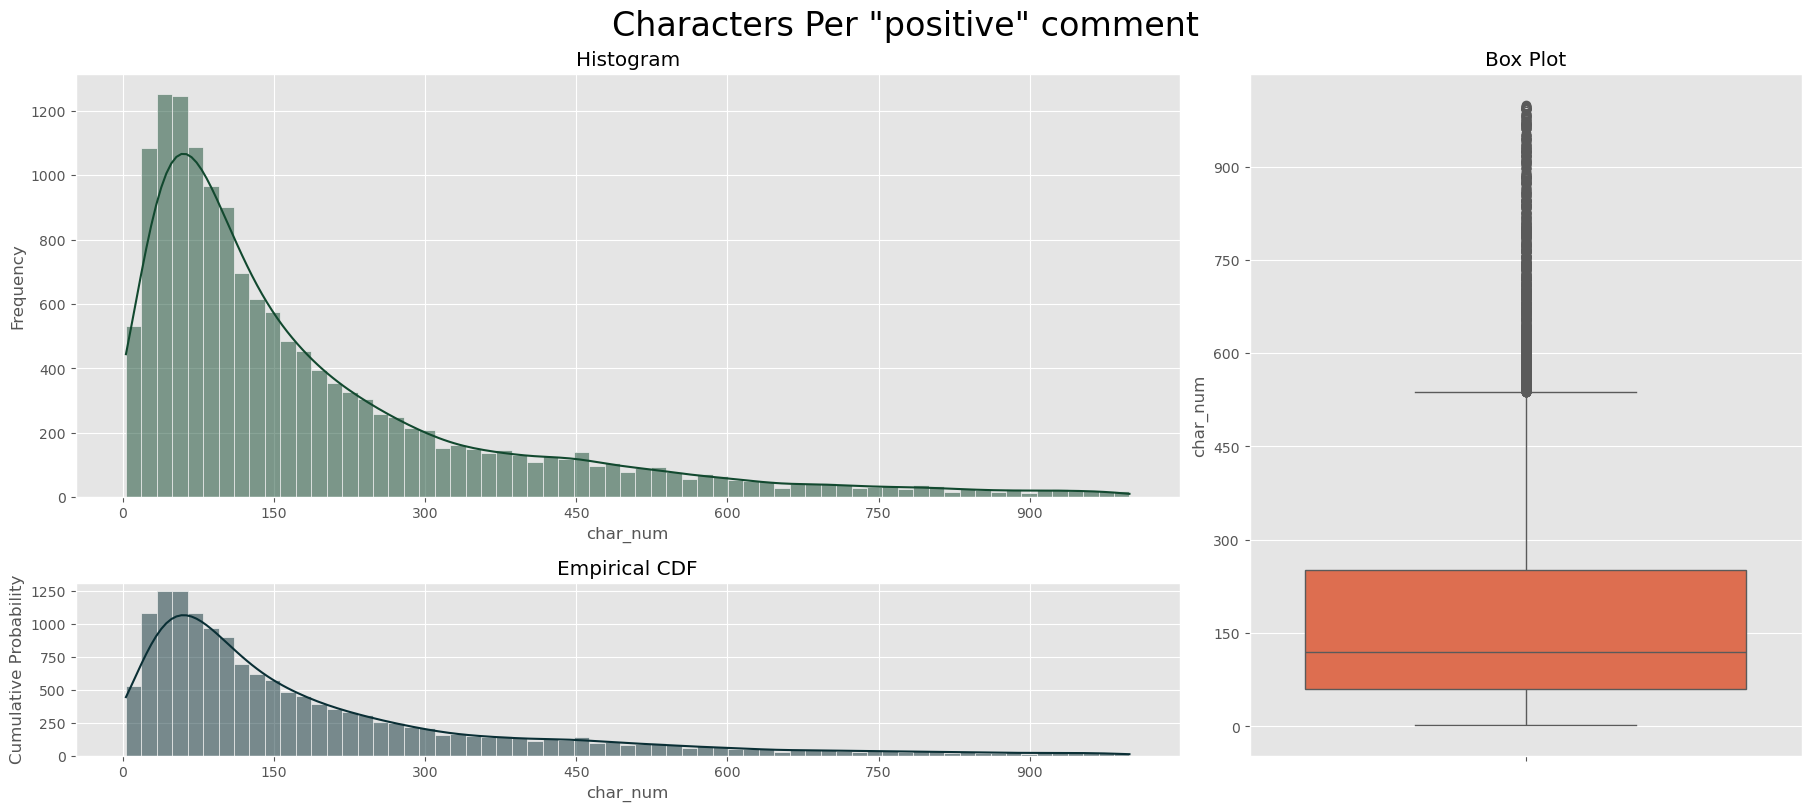

In [15]:
plot_dist3(df[df['sentiment'] == 'positive'], 'char_num',
           'Characters Per "positive" comment')

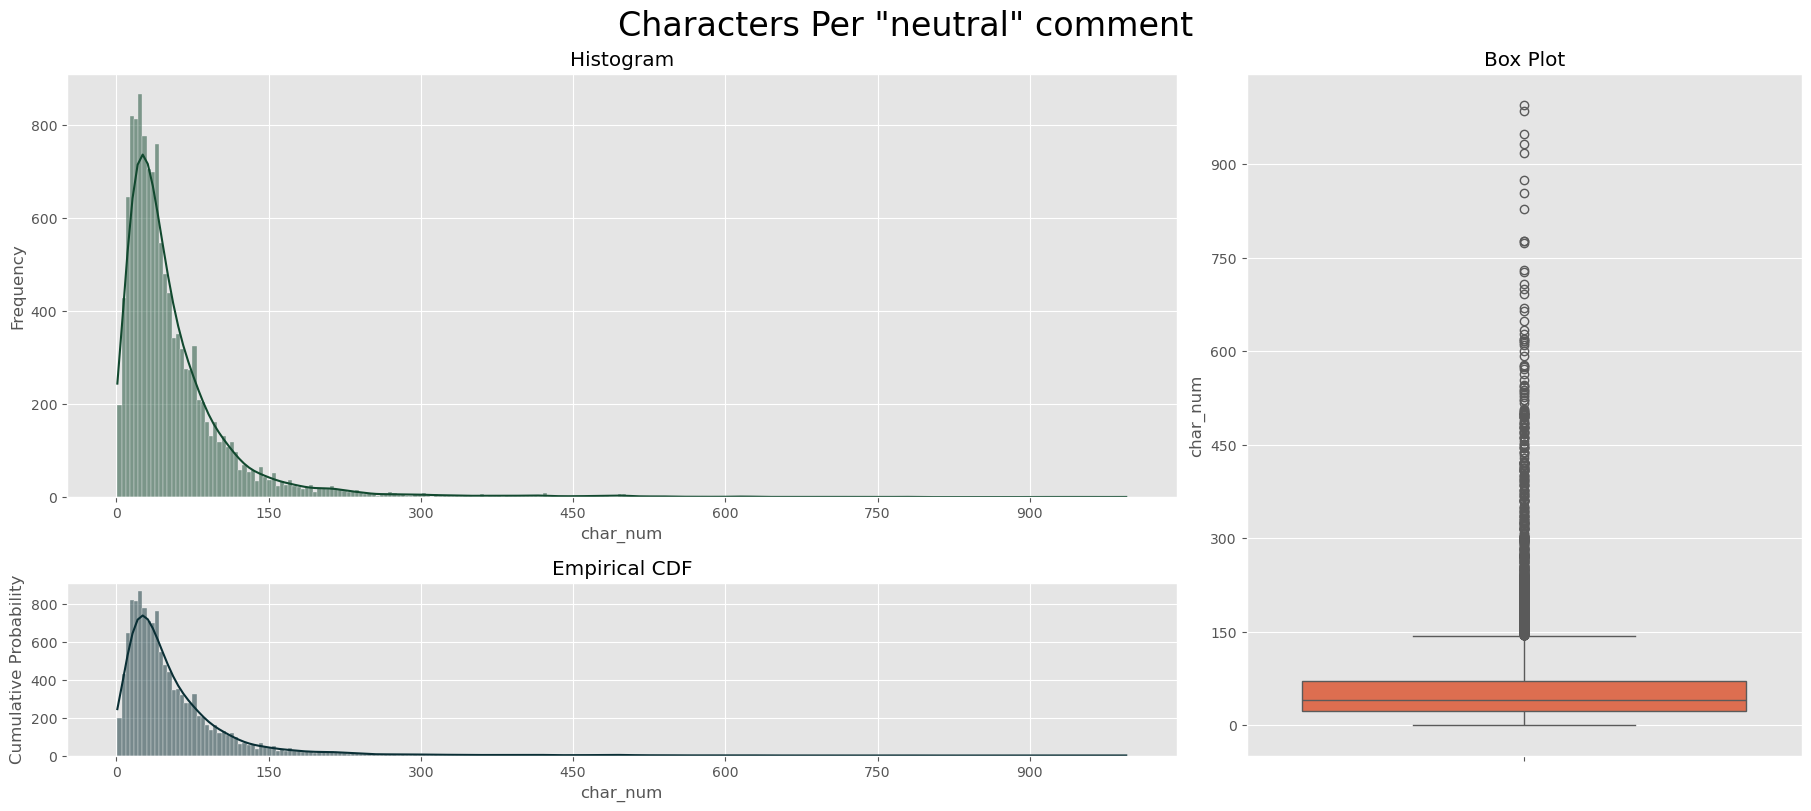

In [16]:
plot_dist3(df[df['sentiment'] == 'neutral'], 'char_num',
           'Characters Per "neutral" comment')

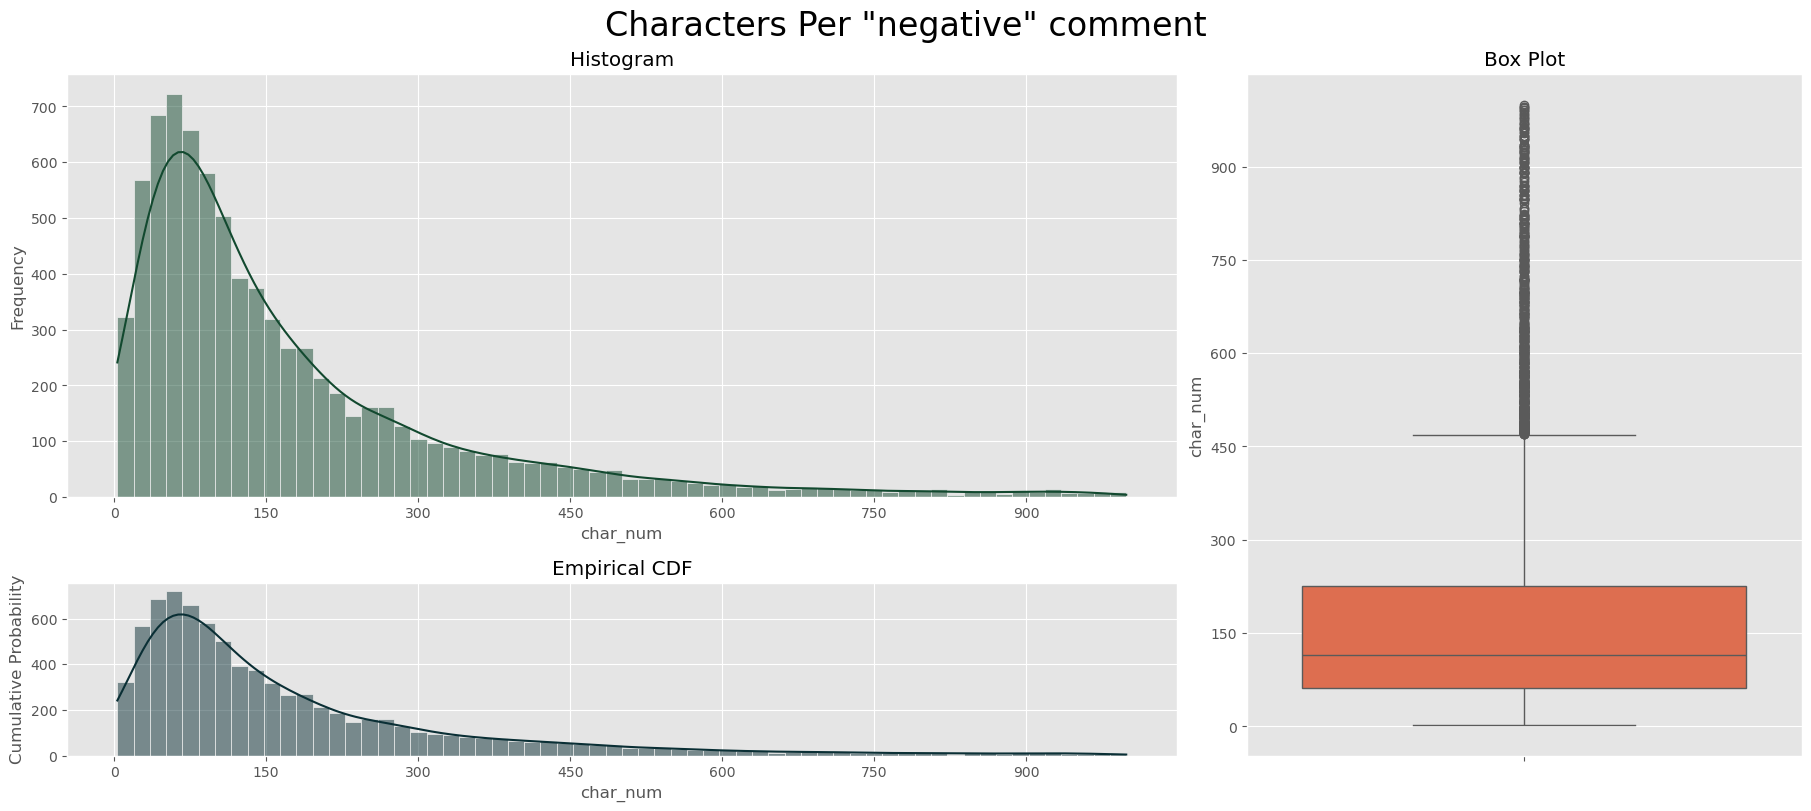

In [17]:
plot_dist3(df[df['sentiment'] == 'negative'], 'char_num',
           'Characters Per "negative" comment')

<h2>5. Word cloud </h2>

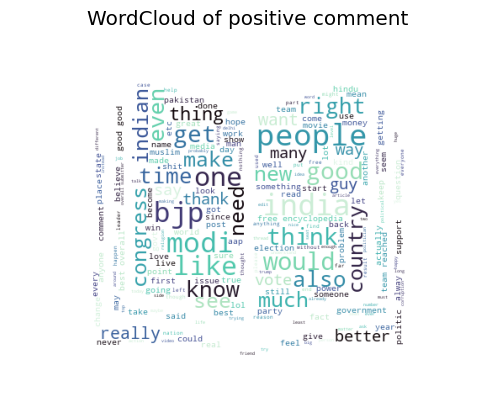

In [18]:
mask = np.array(Image.open('./mask.jpg'))

wc = WordCloud(background_color = "white", 
                max_words = 2000, 
                width = 800, 
                height = 800, 
                mask=mask, 
                colormap = "mako",
                stopwords = stop) \
                .generate(" ".join(df[df['sentiment'] == 'positive']['clean_comment']))

plt.title('WordCloud of positive comment')
plt.axis('off')
plt.imshow(wc)

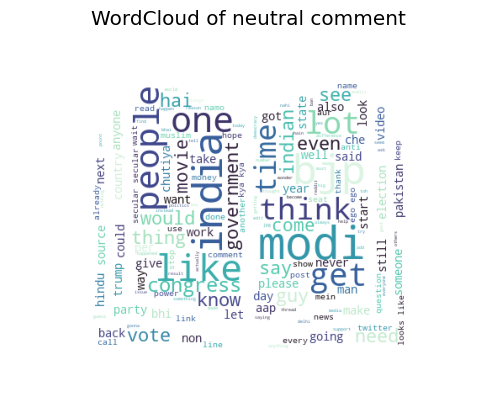

In [19]:
wc = WordCloud(background_color = "white", 
                max_words = 2000, 
                width = 800, 
                height = 800, 
                mask=mask, 
                colormap = "mako",
                stopwords = stop) \
                .generate(" ".join(df[df['sentiment'] == 'neutral']['clean_comment']))

plt.title('WordCloud of neutral comment')
plt.axis('off')
plt.imshow(wc)

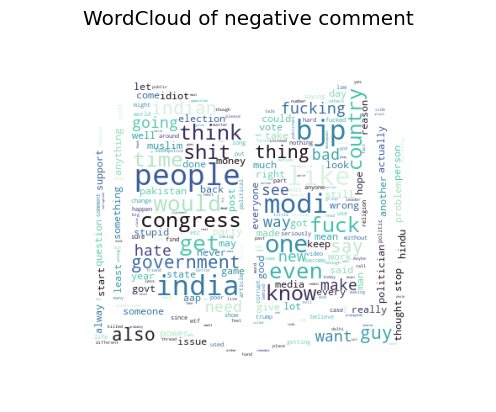

In [20]:
wc = WordCloud(background_color = "white", 
                max_words = 2000, 
                width = 800, 
                height = 800, 
                mask=mask, 
                colormap = "mako",
                stopwords = stop) \
                .generate(" ".join(df[df['sentiment'] == 'negative']['clean_comment']))

plt.title('WordCloud of negative comment')
plt.axis('off')
plt.imshow(wc)

<h2>6. Modelling using RoBERTa </h2>

In [21]:
X = df['clean_comment'].values
y = df['category'].values

label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    encoded_label,
                                                    test_size = 0.2, 
                                                    random_state = 200)

label_mapping = {original_label: int_label for original_label, int_label in zip(y, encoded_label)}
label_mapping

{1: 2, -1: 0, 0: 1}

<h4>Step 1: Seed setting </h4>

In [22]:
# Ask pytorch to use the gpu

if torch.cuda.is_available():    
    device = torch.device('cuda')    

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    
    print('No GPU available, using the CPU instead.')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        
set_seed(161)

No GPU available, using the CPU instead.


<h4>Step 2: Create data loader </h4>

In [23]:
# Import the necessary classes from the transformers library
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tokenizers import ByteLevelBPETokenizer
from transformers import RobertaModel, RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader

In [24]:
# Init path, max length, batch size, learning rate and epochs
MAX_LENGTH = 1000
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EPOCHS = 10

In [28]:
from tqdm.autonotebook import tqdm

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len = 128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize and encode the text using the provided tokenizer
        encoding = self.tokenizer(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        # Return a dictionary containing tokenized data and label
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create Sentiment instances for training and test data
train_data = CommentDataset(X_train, y_train, tokenizer)
test_data = CommentDataset(X_test, y_test, tokenizer)

# Create DataLoader instances for training and test data
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 16)

train_loader = tqdm(train_loader, total = len(train_loader))
test_loader = tqdm(test_loader, total = len(test_loader))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/896 [00:00<?, ?it/s]

In [26]:
class CommentModel(nn.Module):
     
    def __init__(self):
        super(CommentModel, self).__init__()
        
        config = RobertaConfig.from_pretrained('./RoBERTa-base/config.json', 
                                               output_hidden_states = True)    
        self.roberta = RobertaModel.from_pretrained('./RoBERTa-base/pytorch_model.bin', 
                                                    config = config)

        for param in self.roberta.parameters():
            param.requires_grad = True
    
        self.drop0 = nn.Dropout(0.5)
        self.l0 = nn.Linear(config.hidden_size * 2,
                            config.hidden_size)
        
        self.drop1 = nn.Dropout(config.hidden_dropout_prob)
        self.l1 = nn.Linear(config.hidden_size, 2) 
        
        torch.nn.init.normal_(self.l0.weight, std=0.02)
        torch.nn.init.normal_(self.l0.bias, 0)
        
    def forward(self, ids, masks): 
        last_hidden_state, pooled_output, hidden_states = self.roberta(input_ids = ids, 
                                                                       attention_mask = masks, 
                                                                       return_dict = False)
        
        # input_ids.shape and attention_mask.shape both will be of the size (batch size x seq length)
        # print(last_hidden_state.shape) : torch.Size([24, 100, 768])
        # But why 768? 
        # This is the number of hidden units in the feedforward-networks. We can verify that by checking the config.
        # Concatenate the last two hidden states
        out = torch.cat((hidden_states[-1], hidden_states[-2]), dim=-1)   
        # out = torch.mean(out, 0) # take the mean along axis 0
        
        # adding dropouts and linear layers
        out = self.drop0(out)
        out = F.relu(self.l0(out))
        out = self.drop1(out) 
        out = self.l1(out) 
        
        # splitting the tensor into two logits 
        start_logits, end_logits = out.split(1, dim=-1)
        
        # dimension along which to split the tensor.
        # Return a tensor with all the dimensions of input of size 1 removed, for both the logits.
        start_logits = start_logits.squeeze()  
        
        # Squeezing a tensor removes the dimensions or axes that have a length of one
        end_logits = end_logits.squeeze() 
        
        return start_logits, end_logits

In [ ]:
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01, correct_bias=False)

# Loop over training epochs (here, only 1 epoch as training time is too long for a single epoch)
for epoch in range(1):
    model.train()  # Set the model to training mode
    for batch in train_loader:
        optimizer.zero_grad()  # Clear gradients
        input_ids = batch['input_ids'].to(device)  # Move input to the device
        attention_mask = batch['attention_mask'].to(device)  # Move attention mask to the device
        labels = batch['labels'].to(device)  # Move labels to the device
        outputs = model(input_ids, attention_mask = attention_mask, labels=labels)  # Forward pass
        loss = outputs[0]  # Get the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters using gradients

    print('I am here')  # Print a message to indicate completion of an epoch
    
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            test_loss += loss.item()

            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            accuracy = accuracy_score(labels.cpu(), predictions.cpu())
            test_accuracy += accuracy

    test_loss /= len(test_loader)  # Calculate average test loss
    test_accuracy /= len(test_loader)  # Calculate average test accuracy
    print(f'Validation Loss: {test_loss} and Validation Accuracy: {test_accuracy}')